In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import eli5
from sklearn import decomposition
import lightgbm as lgb
import xgboost as xgb

import os
from IPython.display import display_html

In [87]:
PATH_TO_DATA = '../../data/dota_2/'
SEED = 17

In [88]:
df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train_features.csv'), 
                                    index_col='match_id_hash')
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

In [89]:
from sklearn.model_selection import ShuffleSplit, KFold
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=17)

In [90]:
train = df_train_features
y = df_train_targets['radiant_win'].values

In [91]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'test_features.csv'), 
                                    index_col='match_id_hash')

test = df_test_features

In [92]:
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']:
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train['r_total_' + c] = train[r_columns].sum(1) #.astype(np.float32)
    train['d_total_' + c] = train[d_columns].sum(1) #.astype(np.float32)
    train['total_' + c + '_ratio'] = train['r_total_' + c] / train['d_total_' + c].astype(np.float32)
    
    test['r_total_' + c] = test[r_columns].sum(1)
    test['d_total_' + c] = test[d_columns].sum(1)
    test['total_' + c + '_ratio'] = test['r_total_' + c] / test['d_total_' + c]
    
    train['r_std_' + c] = train[r_columns].std(1)
    train['d_std_' + c] = train[d_columns].std(1)
    train['std_' + c + '_ratio'] = train['r_std_' + c] / train['d_std_' + c]
    
    test['r_std_' + c] = test[r_columns].std(1)
    test['d_std_' + c] = test[d_columns].std(1)
    test['std_' + c + '_ratio'] = test['r_std_' + c] / test['d_std_' + c]
    
    train['r_mean_' + c] = train[r_columns].mean(1)
    train['d_mean_' + c] = train[d_columns].mean(1)
    train['mean_' + c + '_ratio'] = train['r_mean_' + c] / train['d_mean_' + c]
    
    test['r_mean_' + c] = test[r_columns].mean(1)
    test['d_mean_' + c] = test[d_columns].mean(1)
    test['mean_' + c + '_ratio'] = test['r_mean_' + c] / test['d_mean_' + c]

In [93]:
X_train = train.copy().reset_index(drop=True)
X_test = test.copy().reset_index(drop=True)

In [94]:
X_train.head(3)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,mean_obs_placed_ratio,r_total_sen_placed,d_total_sen_placed,total_sen_placed_ratio,r_std_sen_placed,d_std_sen_placed,std_sen_placed_ratio,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio
0,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN
1,658,4,0,3,10,15,7,2,0,7,...,0.8,3,2,1.5,0.894427,0.894427,1.0,0.6,0.4,1.5
2,21,23,0,0,0,101,0,0,0,0,...,NaN,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN


In [95]:
X_train[X_train==np.inf]=np.nan
X_train = X_train.fillna(0)

In [96]:
np.all(np.isfinite(X_train.values))

False

In [97]:
np.any(np.isnan(X_train.values))

False

In [98]:
X_train.head(3)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,mean_obs_placed_ratio,r_total_sen_placed,d_total_sen_placed,total_sen_placed_ratio,r_std_sen_placed,d_std_sen_placed,std_sen_placed_ratio,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio
0,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,658,4,0,3,10,15,7,2,0,7,...,0.8,3,2,1.5,0.894427,0.894427,1.0,0.6,0.4,1.5
2,21,23,0,0,0,101,0,0,0,0,...,0.0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


### Let's try LightGBM

In [99]:
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=0.33, random_state=42)
#train_data = lgb.Dataset(X_train, label = y_train)
#valid_data = lgb.Dataset(X_valid, label = y_valid)

In [100]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [101]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [102]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

In [103]:
import  time

Fold 0 started at Fri Nov 15 13:36:03 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.884812	valid_1's auc: 0.824849
[2000]	training's auc: 0.932003	valid_1's auc: 0.825952
Early stopping, best iteration is:
[1859]	training's auc: 0.926358	valid_1's auc: 0.826034
Fold 1 started at Fri Nov 15 13:36:28 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's auc: 0.83397	valid_1's auc: 0.809882
Fold 2 started at Fri Nov 15 13:36:34 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.884354	valid_1's auc: 0.826769
[2000]	training's auc: 0.931022	valid_1's auc: 0.828606
Early stopping, best iteration is:
[1865]	training's auc: 0.925742	valid_1's auc: 0.828739
Fold 3 started at Fri Nov 15 13:36:57 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.884317	valid_1's auc: 0.828448
[2000]	training's auc: 0.93167

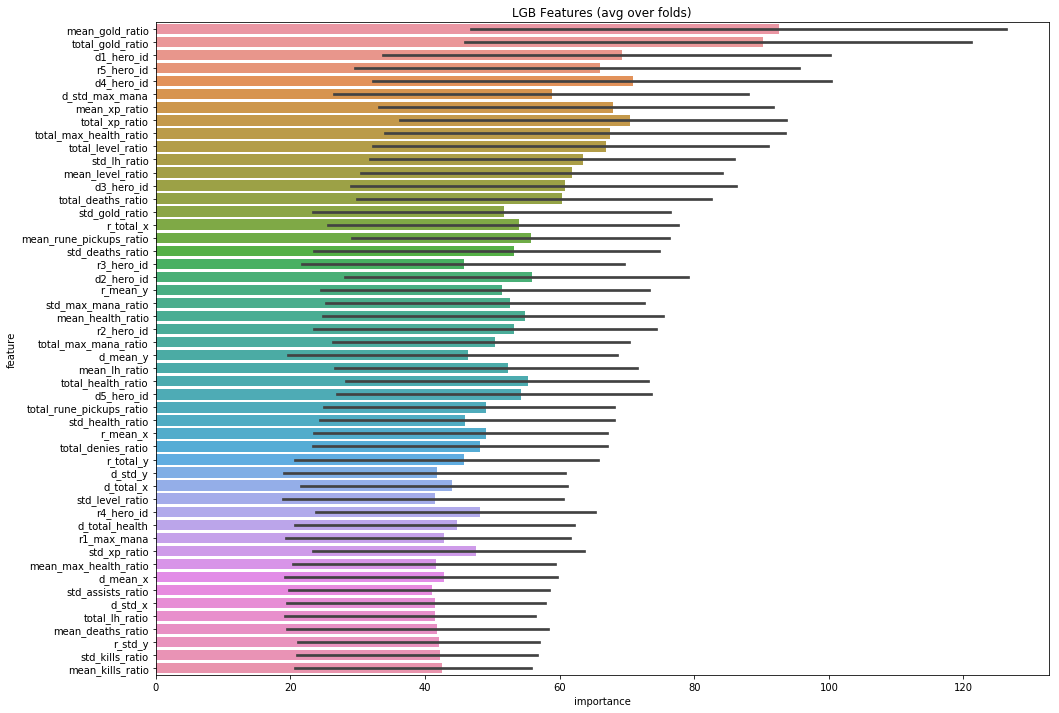

In [104]:
oof_lgb, prediction_lgb, scores = train_model(X_train, X_test, y, params=params, 
                                              folds=folds, model_type='lgb', 
                                              plot_feature_importance=True)

In [108]:
df_submission = pd.DataFrame(
    {'radiant_win_prob': prediction_lgb}, 
    index=df_test_features.index,)

df_submission.to_csv('sumbmission_lgb1_f2.csv')

In [109]:
df_submission.head(3)

,radiant_win_prob
match_id_hash,
30cc2d778dca82f2edb568ce9b585caa,0.519131
70e5ba30f367cea48793b9003fab9d38,0.915385
4d9ef74d3a2025d79e9423105fd73d41,0.900535


In [110]:
pd.to_pickle(X_train, "./train_features_2.pkl")
pd.to_pickle(X_test, "./test_features_2.pkl")

### Play with pca

In [169]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.99)

In [170]:
np.any(np.isinf(X_train))

False

In [148]:
#X_train[X_train==np.inf]=np.nan
#X_train = X_train.fillna(0)
#X_train = X_train.replace([np.inf, -np.inf], np.nan);

In [171]:
np.any(np.isinf(X_train))

False

In [172]:
np.any(np.isnan(X_train))

False

In [173]:
X_train = X_train.fillna(0)

In [174]:
np.any(np.isnan(X_train))

False

In [175]:
X_train_pca = pca.fit_transform(X_train)
#X_test_reduced = pca.transform(X_test)

In [176]:
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(0)
print(np.any(np.isinf(X_test)))
print(np.any(np.isnan(X_test)))

False
False


In [177]:
X_test_pca = pca.transform(X_test)

In [178]:
X_test_pca

array([[-8.58412601e+04, -4.19565682e+01, -4.71866345e+02, ...,
        -3.73927309e+01, -1.68476478e+01,  3.27622196e+01],
       [-1.31203628e+04, -4.37116106e+01,  1.22225291e+04, ...,
         2.44444191e+02, -2.12327874e+03, -3.49236028e+02],
       [-2.05364791e+04, -3.60833199e+01,  1.27371515e+04, ...,
        -1.46161564e+03, -3.24535178e+02,  1.60023509e+03],
       ...,
       [-6.83254391e+04, -3.20204182e+01, -1.41988926e+03, ...,
        -6.66664350e+02,  5.55127739e+02, -3.31628627e+02],
       [-7.47734210e+02,  2.27450364e+00,  1.79000336e+03, ...,
         4.56693270e+03,  2.06286815e+03, -7.89010141e+02],
       [ 2.79398303e+04,  2.12289469e+01, -1.00818462e+04, ...,
        -4.45982907e+03, -8.44146404e+02,  1.66557572e+03]])

In [179]:
pca.components_

array([[ 1.00481157e-02,  1.69154761e-06, -1.21283808e-06, ...,
         1.01012542e-05,  1.00466703e-05,  6.48992522e-06],
       [-3.41427219e-05,  1.97063057e-07,  1.34871948e-06, ...,
        -5.10469628e-08, -4.56229844e-07, -7.20422196e-10],
       [ 4.61172549e-04,  6.53978176e-06, -1.72752260e-07, ...,
        -5.41542735e-06,  5.78009539e-06, -7.75531889e-06],
       ...,
       [ 8.04425085e-06, -6.06080596e-06, -3.22658831e-06, ...,
        -4.29155759e-06,  2.49930719e-06, -7.89638833e-06],
       [ 1.89630753e-04, -1.02993682e-06, -9.70310617e-07, ...,
         2.17985661e-06,  7.97725886e-07,  4.16342298e-06],
       [-7.60951158e-04,  8.60449856e-06, -3.10855472e-06, ...,
        -1.58757351e-06,  2.39820748e-07, -3.72169249e-06]])

In [180]:
pca.n_components_

12

In [181]:
pca.explained_variance_ratio_

array([0.92364002, 0.02033264, 0.01460936, 0.00794545, 0.00552815,
       0.00275941, 0.00267686, 0.00265247, 0.00263911, 0.00260069,
       0.00258487, 0.00253339])

In [182]:
def plotPCA(pca):
    """
    Plots accumulated percentage of explained variance by component
    
    pca: fitted PCA object
    """
    components = range(1, pca.n_components_ + 1)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.figure(figsize=(20, 10))
    plt.bar(components, variance)
    
    # additionally mark the level of 95% of explained variance 
    plt.hlines(y = 99, xmin=0, xmax=len(components), linestyles='dashed', colors='red')
    
    plt.xlabel('PCA components')
    plt.ylabel('variance')
    plt.xticks(components)
    plt.show()

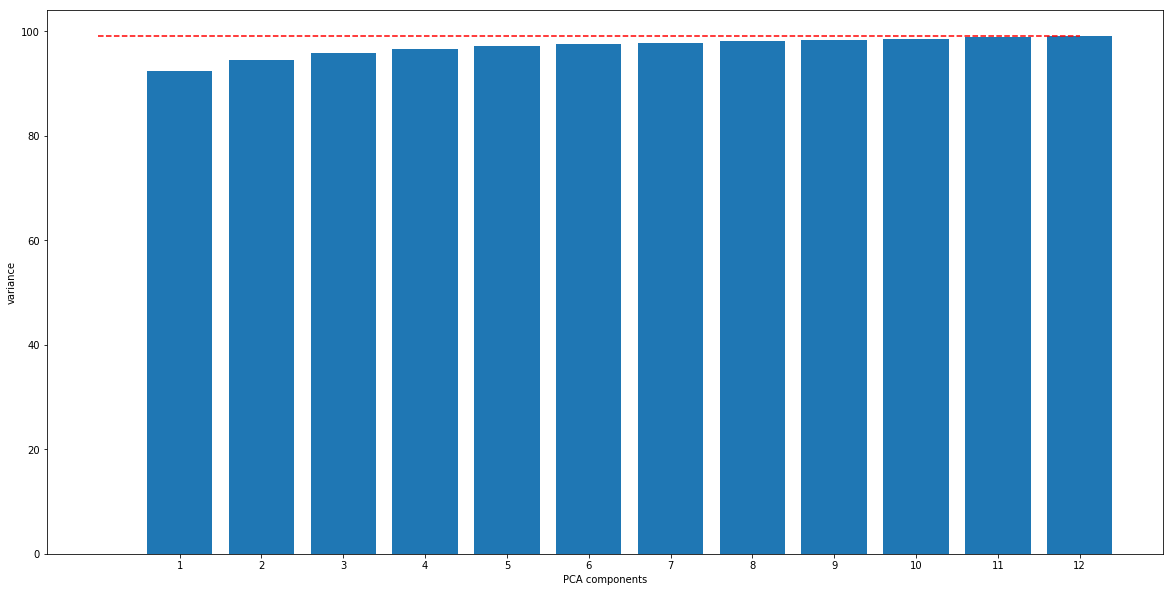

In [183]:
plotPCA(pca)

In [130]:
oof_lgb_pca, prediction_lgb_pca, scores_pca = train_model(X_train_reduced, X_test_reduced, y, params=params, 
                                              folds=folds, model_type='lgb', 
                                              plot_feature_importance=True)

Fold 0 started at Fri Nov 15 14:17:37 2019


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

### Random Forest

In [139]:
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)

cv_scores = cross_val_score(model_rf, X_train, y, 
                                     cv=cv, scoring='roc_auc', n_jobs=-1)

In [140]:
print(cv_scores.mean(), cv_scores.std())

0.8166197452803926 0.0009705964732906254


In [184]:
X_train_pca.shape

(39675, 12)

In [185]:
# PCA components with random forest

cv_scores = cross_val_score(model_rf, X_train_pca, y, 
                                     cv=cv, scoring='roc_auc', n_jobs=-1)

In [186]:
print(cv_scores.mean(), cv_scores.std())

0.8067507711017378 0.0009122708169682995


### LGB with PCA

In [187]:
X_train_reduced, X_valid_reduced, y_train, y_valid = train_test_split(X_train_pca, y, test_size=0.33, random_state=42)
train_data_reduced = lgb.Dataset(X_train_reduced, label = y_train)
valid_data_reduced = lgb.Dataset(X_valid_reduced, label = y_valid)

In [188]:
model = lgb.train(params,
                    train_data_reduced,
                    num_boost_round=20000,
                    valid_sets = [train_data_reduced, valid_data_reduced],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[545]	training's auc: 0.836655	valid_1's auc: 0.810554


In [189]:
y_pred_pca = model.predict(X_test_pca, num_iteration=model.best_iteration)

In [190]:
df_submission = pd.DataFrame(
    {'radiant_win_prob': y_pred_pca}, 
    index=df_test_features.index,)

df_submission.to_csv('sumbmission_lgb1_f2_played with pca.csv')

In [191]:
np.save('f2_train_numpy',X_train)

In [192]:
np.save('f2_test_numpy',X_test)